# CS273P Project -- Temporal Fusion Transformer

Import necessary libraries

In [1]:
# Imports
import math
import copy
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")

## Read in data

In [2]:
# Read the csv files
transactions = pd.read_csv("./transactions.csv")
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
stores = pd.read_csv("./stores.csv")
sample_submission = pd.read_csv("./sample_submission.csv")
oil = pd.read_csv("./oil.csv")
holidays = pd.read_csv("./holidays_events.csv")

## Get a feel for the data

Initially decided to group by family, and check the sales on the **train** dataset.

In order to get a familiarized with the data, plotted default, boxplot, and violinplot graphs.

In [3]:
train = pd.read_csv("./train.csv")

Sales seems to be right-skewed, regardless of family.

One thing to note is that the scale of sales varies greatly between families of products.  Additionally, some family sales fluctuate consistently with total sales, whereas other product families have spikes in regular increments over time. 

Spikes in transactions seem to be mostly consistent with spikes in sales.

Plotting oil price over time shows a significant drop in oil price midway through the duration measured by the dataset.

## Clean up dataframes before joining to train

Null oil prices will be filled with previous day's price -- first day is null, so take second day's price.

In [4]:
# Set first oil line to match next day (originally missing)
oil["dcoilwtico"][0] = oil["dcoilwtico"][1]

Split holidays by locale for easy of merging.  Rename columns to avoid ambiguity later on when joining columns.

In [5]:
# Isolate national holidays and format columns as needed
national_holidays = holidays[holidays["locale"]=="National"].copy()
national_holidays = national_holidays.drop('locale_name', 1)
national_holidays.rename(columns={"type":"type1", 
                                  "locale":"locale1",
                                  "description":"description1",
                                  "transferred":"transferred1"},inplace=True)
national_holidays["date"] = national_holidays["date"].astype("str")

# Isolate regional holidays and format columns as needed
regional_holidays = holidays[holidays["locale"]=="Regional"].copy()
regional_holidays.rename(columns={"locale_name":"state"},inplace=True)
regional_holidays.rename(columns={"type":"type2", 
                                  "locale":"locale2",
                                  "description":"description2",
                                  "transferred":"transferred2"},inplace=True)

# Isolate local holidays and format columns as needed
local_holidays = holidays[holidays["locale"]=="Local"].copy()
local_holidays.rename(columns={"locale_name":"city"},inplace=True)
local_holidays.rename(columns={"type":"type3", 
                               "locale":"locale3",
                               "description":"description3",
                               "transferred":"transferred3"},inplace=True)

Merge training dataset and other dataframes into single dataframe.

Handle null values as specified below:

In [6]:
master_df = pd.merge(train, stores, on="store_nbr", how="left")
master_df = pd.merge(master_df, transactions, on=["date","store_nbr"],how="left")
master_df["transactions"] = master_df["transactions"].fillna(0) # Set transaction na's to 0
master_df = pd.merge(master_df, oil, on="date", how="left")
master_df["dcoilwtico"] = master_df["dcoilwtico"].fillna(method="ffill") # Set missing oil prices to previous value

Now merge holidays and create the "actual" columns for the holiday data.

In [7]:
master_df = pd.merge(master_df, national_holidays, on="date", how="left")
master_df = pd.merge(master_df, regional_holidays, on=["date", "state"], how="left")
master_df = pd.merge(master_df, local_holidays, on=["date", "city"], how="left")

master_df["holiday_type"] = "None"
master_df["locale"] = "None"
master_df["description"] = "None"
master_df["transferred"] = False

Join holiday columns, then drop the duplicate/working columns.

In [8]:
# Join holiday columns into respective "actual" columns
master_df["holiday_type"] = master_df["type1"].fillna("") + master_df["type2"].fillna("") + master_df["type3"].fillna("")
master_df["locale"] = master_df["locale1"].fillna("") + master_df["locale2"].fillna("") + master_df["locale3"].fillna("")
master_df["description"] = master_df["description1"].fillna("") + master_df["description2"].fillna("") + master_df["description3"].fillna("")
master_df["transferred"] = master_df["transferred1"].fillna(0) + master_df["transferred2"].fillna(0) + master_df["transferred3"].fillna(0)

In [9]:
# Drop working columns
master_df = master_df.drop(["transferred1","transferred2","transferred3",
                            "type1","type2","type3",
                            "locale1","locale2","locale3",
                            "description1","description2","description3"],
                           1)

Convert strings to categorial variables, then plot heatmap

In [10]:
master_df_cat = master_df

master_df_cat["date"] = master_df_cat["date"].astype({"date": "datetime64[ns]"})
master_df_cat["family"] = master_df_cat["family"].astype("category").cat.codes
master_df_cat["city"] = master_df_cat["city"].astype("category").cat.codes
master_df_cat["state"] = master_df_cat["state"].astype("category").cat.codes
master_df_cat["type"] = master_df_cat["type"].astype("category").cat.codes
master_df_cat["holiday_type"] = master_df_cat["holiday_type"].astype("category").cat.codes
master_df_cat["transferred"] = master_df_cat["transferred"].astype("bool")
master_df_cat["locale"] = master_df_cat["locale"].astype("category").cat.codes
master_df_cat["description"] = master_df_cat["description"].astype("category").cat.codes

In [11]:
master_df_cat["time_i"] = (master_df_cat["date"].dt.date - master_df_cat['date'].dt.date.min()).dt.days
master_df_cat["year"] = master_df_cat["date"].dt.year
master_df_cat["month"] = master_df_cat["date"].dt.month
master_df_cat["day"] = master_df_cat["date"].dt.day
master_df_cat["day_of_week"] = master_df_cat["date"].dt.dayofweek
master_df_cat.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,dcoilwtico,holiday_type,locale,description,transferred,time_i,year,month,day,day_of_week
0,0,2013-01-01,1,0,0.0,0,18,12,3,13,...,93.14,6,2,55,False,0,2013,1,1,1
1,1,2013-01-01,1,1,0.0,0,18,12,3,13,...,93.14,6,2,55,False,0,2013,1,1,1
2,2,2013-01-01,1,2,0.0,0,18,12,3,13,...,93.14,6,2,55,False,0,2013,1,1,1
3,3,2013-01-01,1,3,0.0,0,18,12,3,13,...,93.14,6,2,55,False,0,2013,1,1,1
4,4,2013-01-01,1,4,0.0,0,18,12,3,13,...,93.14,6,2,55,False,0,2013,1,1,1


<AxesSubplot:>

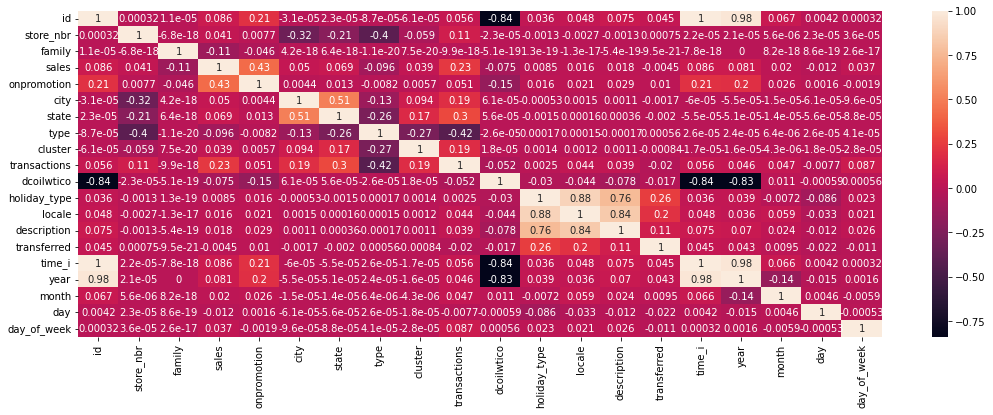

In [12]:
# Plot heatmap
plt.figure(figsize = (18,6))
sns.heatmap(master_df_cat.corr(),annot=True)

According to the heatmap, it seems that *onpromotion* and *transactions* (total at store on given day) are the greatest contributors to sales.  *Family* also seems to have some correlation (since it's supposed to be categorical, I don't think that the sign matters too much)

There are also smaller points of interest that may be worth exploring, such as the effect of *dcoilwtico* on *onpromotion*.  Additionally, the city, state, and cluster seems to affect the total amount of transactions at a store.

In [13]:
new_col_order = [x for x in master_df_cat.columns if x != "sales"]
new_col_order.append("sales")
final_df = master_df_cat[new_col_order]
final_df

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,...,holiday_type,locale,description,transferred,time_i,year,month,day,day_of_week,sales
0,0,2013-01-01,1,0,0,18,12,3,13,0.0,...,6,2,55,False,0,2013,1,1,1,0.000
1,1,2013-01-01,1,1,0,18,12,3,13,0.0,...,6,2,55,False,0,2013,1,1,1,0.000
2,2,2013-01-01,1,2,0,18,12,3,13,0.0,...,6,2,55,False,0,2013,1,1,1,0.000
3,3,2013-01-01,1,3,0,18,12,3,13,0.0,...,6,2,55,False,0,2013,1,1,1,0.000
4,4,2013-01-01,1,4,0,18,12,3,13,0.0,...,6,2,55,False,0,2013,1,1,1,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,28,0,18,12,1,6,2155.0,...,0,0,0,False,1687,2017,8,15,1,438.133
3008276,3000884,2017-08-15,9,29,1,18,12,1,6,2155.0,...,0,0,0,False,1687,2017,8,15,1,154.553
3008277,3000885,2017-08-15,9,30,148,18,12,1,6,2155.0,...,0,0,0,False,1687,2017,8,15,1,2419.729
3008278,3000886,2017-08-15,9,31,8,18,12,1,6,2155.0,...,0,0,0,False,1687,2017,8,15,1,121.000


In [16]:
final_df = final_df.sort_values(["time_i", "family", "store_nbr"])

# Temporal Fusion Transformers Model
Initial reference: https://www.kaggle.com/code/shreyasajal/pytorch-forecasting-for-time-series-forecasting/notebook

## Why Temporal Fusion Transformers?

Originally, we set out to implement a transformer model. However, after further research, Temporal Fusion Transformers (TFTs) appeared to be an attractive solution to this problem, as they seemed to be well optimized for time series forecasting problems. A TFT is a hybrid model that utilizes the multi-head attention mechanisms found in transformers alongside with LSTM encoder and decoder blocks.

https://towardsdatascience.com/temporal-fusion-transformer-a-primer-on-deep-forecasting-in-python-4eb37f3f3594

In [17]:
# For GPU
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
max_pred_len = 7    # Predict up to 7 time steps at a time
max_encoder_len = 60    # Max length of sequence to encode
train_cutoff = final_df["time_i"].max() - max_pred_len

First, convert final_df to a TimeSeriesDataSet. Once we get training and validation TimeSeriesDataSets, we will be able to pass into a dataloader.

In [19]:
ts_train = TimeSeriesDataSet(final_df[lambda x: x["time_i"] <= train_cutoff],
                             time_idx = "time_i",    # Time step
                             target = "sales",    
                             group_ids = ["family", "store_nbr"],    # Groups to identify by
                             min_encoder_length = 0,
                             max_encoder_length = max_encoder_len,
                             min_prediction_length = 1,
                             max_prediction_length = max_pred_len,
                             static_categoricals = [],
                             static_reals = ["family", "store_nbr"],    # Do not change over time
                             time_varying_known_categoricals = [],
                             time_varying_known_reals = ["time_i"],    # Change over time and are known
                             time_varying_unknown_categoricals = [],
                             time_varying_unknown_reals = ["time_i"],    # Change over time and are unknown
                             target_normalizer = GroupNormalizer(groups = ["family", "store_nbr"], transformation = "softplus"),   # Normalize targets
                             categorical_encoders = {"store_nbr": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan = True)},    # Account for na's
                             add_relative_time_idx = True,
                             add_target_scales = True,
                             add_encoder_length = True,
                             allow_missing_timesteps = True)    # Allow for missing timesteps (steps greater than 1)

Split to get a validation TimeSeriesDataSet.

Load training and validation sets into dataloaders.

In [20]:
ts_val = TimeSeriesDataSet.from_dataset(ts_train, final_df, predict = True, stop_randomization = True)

batch_size = 128
train_dataloader = ts_train.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = ts_val.to_dataloader(train = False, batch_size = batch_size * 10, num_workers = 0)

Set global seed, then initialize Trainer so that we can calculate a suggested value for the model's learning rate.

In [21]:
pl.seed_everything(17)
trainer = pl.Trainer(gpus = 1, gradient_clip_val = .1)

Global seed set to 17
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Create a TFT -- this will be used to tune the learning rate.

In [22]:
# TFT model
tft = TemporalFusionTransformer.from_dataset(ts_train,
                                            learning_rate = .03,
                                            hidden_size = 16,
                                            attention_head_size = 2,
                                            dropout = .1,
                                            hidden_continuous_size = 8,
                                            output_size = 1,
                                            loss = pytorch_forecasting.metrics.RMSE(),
                                            reduce_on_plateau_patience = 4)

print(f"Number of parameters in network: {tft.size()}")

Number of parameters in network: 19.1k


The below finds an optimal learning rate given the TFT created above.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at C:\Users\cdgut\Documents\Academics\UCI\Winter 2022\CS273P\Project\Project 1\lr_find_temp_model_1baa4069-ce22-4786-84d5-9d143d4b4c73.ckpt


Suggested learning rate: 4.5708818961487505e-07


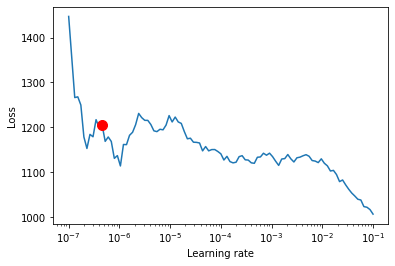

In [23]:
# Use res to find optimal learning rate
res = trainer.tuner.lr_find(tft, 
                            train_dataloader = train_dataloader,
                            val_dataloaders = val_dataloader,
                            max_lr = .1,
                            min_lr = 1e-7)

# Get suggestion from res
suggest_lr = res.suggestion()
print(f"Suggested learning rate: {suggest_lr}")
fig = res.plot(show = True, suggest = True)
fig.show()

In [24]:
# EarlyStopping -- able to stop epoch early given val_loss
early_stop_callback = EarlyStopping(monitor = "val_loss",
                                   min_delta = 1e-7,
                                   patience = 10,
                                   verbose = False,
                                   mode = "min")

# Log learning rate during training
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

# Create trainer w/ early stopping
trainer = pl.Trainer(max_epochs = 30,
                    gpus = 1,
                    weights_summary = "top",
                    gradient_clip_val = .1,
                    limit_train_batches = 30,
                    callbacks = [lr_logger, early_stop_callback],
                    logger = logger)

# Create TFT model using suggested learning rate from previous cell
tft = TemporalFusionTransformer.from_dataset(ts_train,
                                            learning_rate = suggest_lr,
                                            hidden_size = 16,
                                            attention_head_size = 2,
                                            dropout = .1,
                                            hidden_continuous_size = 8,
                                            output_size = 7,
                                            loss = QuantileLoss(),
                                            reduce_on_plateau_patience = 4)

print(f"Number of parameters in network: {tft.size()}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 19.2k


Now, fit the initial TFT model using the training data and validation data.

In [25]:
trainer.fit(tft, train_dataloader = train_dataloader, val_dataloaders = val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 112   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 17


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Now save the path to the best model from fit(), and create new TFT model from that path.

In [26]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [27]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])    # Retrieve actuals
val_predictions = best_tft_model.predict(val_dataloader)    # Predict target on validation data

In [28]:
# Calculate loss
criterion = nn.MSELoss()
loss = torch.sqrt(criterion(actuals, val_predictions))/len(val_predictions)
loss = loss.item()

In [29]:
print(f"loss: {round(loss * 100, 4)}%")

loss: 43.3288%


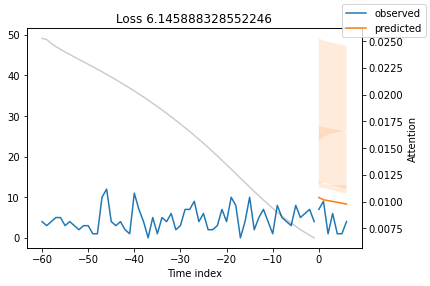

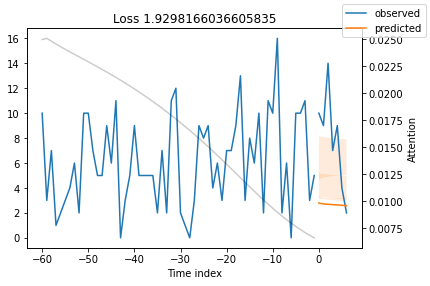

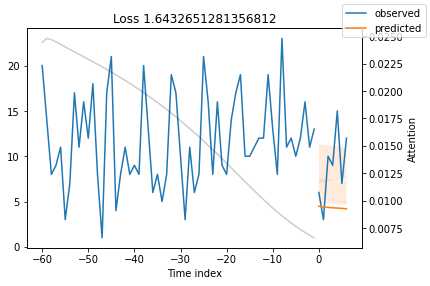

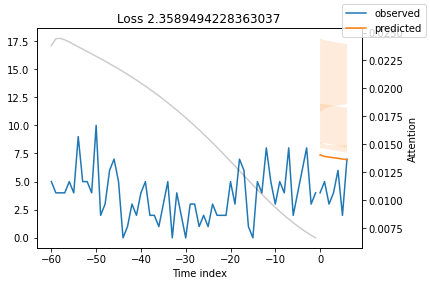

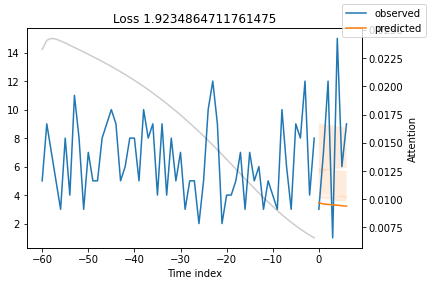

In [30]:
val_predictions, x = best_tft_model.predict(val_dataloader, mode = "raw", return_x = True)

for i in range(5):
    best_tft_model.plot_prediction(x, val_predictions, idx = i, add_loss_to_title = True)

# Optimize TFT Model (Optuna)

Source: https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36
https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

Now that we have a basis for the TFT model, we need to attempt to optimize the model.

Optuna is a framework that runs multiple trials using different optimizers (["Adam", "RMSprop", "SGD"]), accepts parameters that need to be tuned, and prunes poor performing iterations.

In [31]:
torch.cuda.empty_cache()

# Optimize hyperparameters using Optuna Test
hp_opt_study = optimize_hyperparameters(train_dataloader,
                                        val_dataloader,
                                        model_path = "optuna_test",
                                        n_trials = 50,
                                        max_epochs = 30,
                                        gradient_clip_val_range = (.01, 1),
                                        hidden_size_range = (8, 64),
                                        attention_head_size_range = (1, 4),
                                        learning_rate_range = (.001, .1),
                                        dropout_range = (.01, .3),
                                        trainer_kwargs = dict(limit_train_batches = 30, 
                                                              log_every_n_steps = 15, 
                                                              gpus = 1),
                                        reduce_on_plateau_patience = 4,
                                        use_learning_rate_finder = False,
                                        timeout = 4200)

print(hp_opt_study.best_trial.params)

[I 2022-03-19 04:47:50,289] A new study created in memory with name: no-name-1e40f702-39d5-4746-8d02-81c3ac2adbc5
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 04:51:25,755] Trial 0 finished with value: 68.23473358154297 and parameters: {'gradient_clip_val': 0.4002158791835591, 'hidden_size': 24, 'dropout': 0.11663455214804597, 'hidden_continuous_size': 14, 'attention_head_size': 2, 'learning_rate': 0.09217558569364}. Best is trial 0 with value: 68.23473358154297.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 04:54:45,313] Trial 1 finished with value: 66.8779296875 and parameters: {'gradient_clip_val': 0.594213881550686, 'hidden_size': 8, 'dropout': 0.1323693268175739, 'hidden_continuous_size': 8, 'attention_

IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 05:10:01,725] Trial 28 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 05:10:38,847] Trial 29 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 05:11:16,514] Trial 30 pruned. Trial was pruned at epoch 4.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 17
[I 2022-03-19 05:11:32,326] Trial 31 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU availabl

{'gradient_clip_val': 0.9922242475827462, 'hidden_size': 40, 'dropout': 0.19186007457399917, 'hidden_continuous_size': 25, 'attention_head_size': 3, 'learning_rate': 0.022253606222453676}


In [32]:
opt_max_epochs = 200
limit_train_batches = 30

# Store optimized hyperparameters to variables
gradient_clip_val = hp_opt_study.best_trial.params["gradient_clip_val"]
opt_lr = hp_opt_study.best_trial.params["learning_rate"]
opt_hidden_size = hp_opt_study.best_trial.params["hidden_size"]
opt_dropout = hp_opt_study.best_trial.params["dropout"]
opt_att_head_size = hp_opt_study.best_trial.params["attention_head_size"]
opt_hid_cont_size = hp_opt_study.best_trial.params["hidden_continuous_size"]
output_size = 7
reduce_on_plateau_patience = 5

In [33]:
torch.cuda.empty_cache()
# Trainer w/ optimized parameters
trainer = pl.Trainer(max_epochs = opt_max_epochs,
                    gpus = 1,
                    weights_summary = "top",
                    gradient_clip_val = gradient_clip_val,
                    limit_train_batches = limit_train_batches,
                    callbacks = [lr_logger, early_stop_callback],
                    logger = logger)

# TFT model w/ optimized parameters
tft = TemporalFusionTransformer.from_dataset(ts_train,
                                            learning_rate = opt_lr,
                                            hidden_size = opt_hidden_size,
                                            attention_head_size = opt_att_head_size,
                                            dropout = opt_dropout,
                                            hidden_continuous_size = opt_hid_cont_size,
                                            output_size = output_size,
                                            loss = QuantileLoss(),
                                            reduce_on_plateau_patience = reduce_on_plateau_patience)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [34]:
trainer.fit(tft, train_dataloader = train_dataloader, val_dataloaders = val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 350   
4  | static_variable_selection          | VariableSelectionNetwork        | 18.9 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 7.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 6.6 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 6.6 K 
9  | static_context_initial_cell_lstm 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 17


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [35]:
# Save best model path and create TFT from best model path
best_opt_model_path = trainer.checkpoint_callback.best_model_path
best_opt_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_opt_model_path)

In [36]:
actuals = torch.cat([y[0] for x, y in  iter(val_dataloader)])
val_predictions = best_opt_tft_model.predict(val_dataloader)

criterion = nn.MSELoss()
loss = torch.sqrt(criterion(actuals, val_predictions))/len(val_predictions)
loss = loss.item()
print(f"Loss: {round(loss * 100, 4)}%")

Loss: 40.2974%


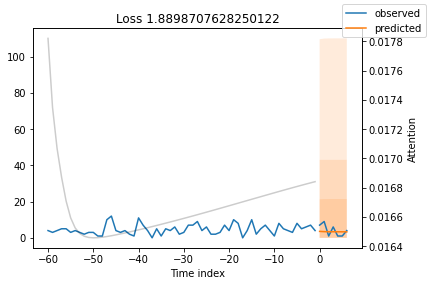

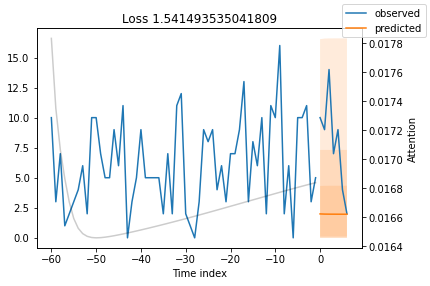

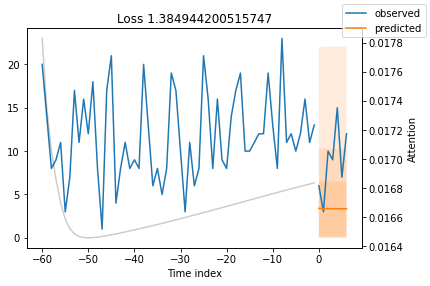

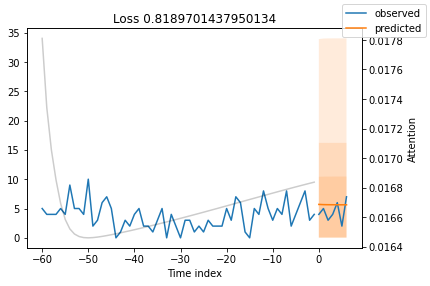

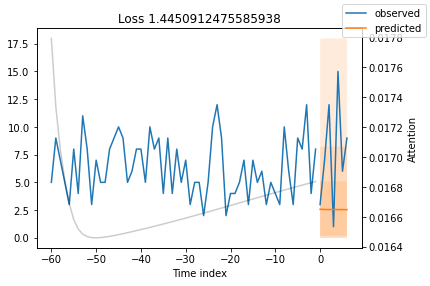

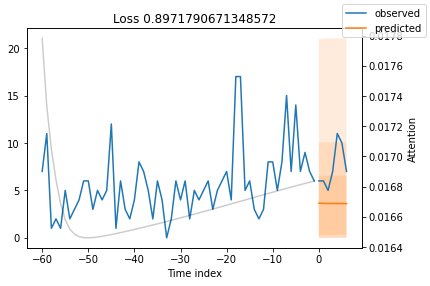

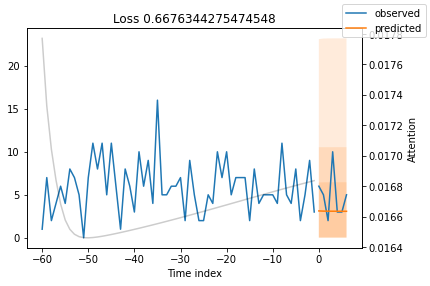

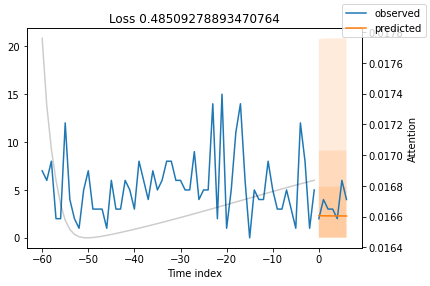

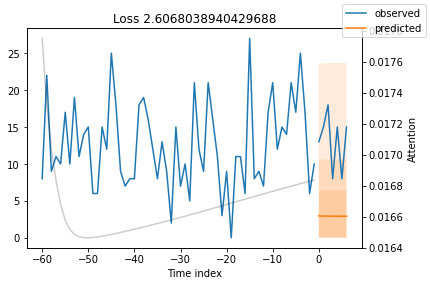

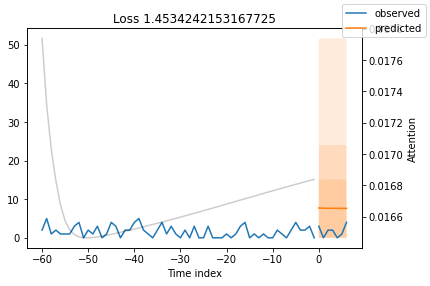

In [37]:
val_predictions, x = best_opt_tft_model.predict(val_dataloader, mode = "raw", return_x = True)

for i in range(10):
    best_opt_tft_model.plot_prediction(x, val_predictions, idx = i, add_loss_to_title = True)